## DATASET

### Bajada y descompresión del dataset

In [ ]:
# Descargamos el dataset (https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
!gdown 1Yzm5qr2mMm9kS7zDM-4L5cUYMtZC8i8w -O datasets/

Downloading...
From: https://drive.google.com/uc?id=1Yzm5qr2mMm9kS7zDM-4L5cUYMtZC8i8w
To: /content/datasets/ASL-MNIST.zip
100% 65.6M/65.6M [00:02<00:00, 22.7MB/s]


In [ ]:
# Descomprimimos el dataset
!unzip datasets/ASL-MNIST.zip -d datasets/ASL-MNIST/

Archive:  datasets/ASL-MNIST.zip
  inflating: datasets/ASL-MNIST/amer_sign2.png  
  inflating: datasets/ASL-MNIST/amer_sign3.png  
  inflating: datasets/ASL-MNIST/american_sign_language.PNG  
  inflating: datasets/ASL-MNIST/sign_mnist_test.csv  
  inflating: datasets/ASL-MNIST/sign_mnist_test/sign_mnist_test.csv  
  inflating: datasets/ASL-MNIST/sign_mnist_train.csv  
  inflating: datasets/ASL-MNIST/sign_mnist_train/sign_mnist_train.csv  


In [ ]:
# Carpeta de salida para guardar los modelos etrenados y otras cosas
!mkdir trained_models

### Carga de las imágenes y etiquetas del dataset

El dataset contiene muestras sobre las letras del alfabeto (de la A a la Z) representadas en la lengua de signos americana.

Los datos se guardan en formato CSV. Cuenta con dos particiones diferenciadas de entrenamiento y validación:
- Entrenamiento. Se guarda en ASL-MNIST/sign_mnist_train/sign_mnist_train.csv. Cuenta con 27455 muestras.
- Validación. Se guarda en ASL-MNIST/sign_mnist_test/sign_mnist_test.csv. Cuenta con 7172 muestras.

Importante:
- Las etiquetas son numéricas (del 0 al 25) y representan una relación de uno a uno para cada letra alfabética A-Z, EXCLUYENDO las letras J (9)
y Z (25) debido a que su representación no es estática.
- Las imágenes están en escala de grises y tienen un tamaño original de 28x28 píxeles.

In [ ]:
import string
import numpy as np
import pandas as pd

# Diccionario que nos permite mapear el valor numérico a la letra con la que se corresponde
i2c = {k:v for k, v in enumerate(list(string.ascii_uppercase))}
# Lo guardamos en un fichero para luego poder llamarlo desde la aplicación
np.save('trained_models/i2c.npy', i2c)

def load_data_partition(train: bool = True):
    partition = 'train' if train else 'test'
    # Leemos el fichero CSV
    df = pd.read_csv(f'datasets/ASL-MNIST/sign_mnist_{partition}/sign_mnist_{partition}.csv')
    # Obtenemos las etiquetas:
    Y = df['label'].to_numpy()      # Valores numéricos
    del df['label']
    # Obtenemos las imágenes:
    X = df.values
    X = X / 255                     # Normalizamos las imágenes: los píxeles están en el rango [0 (negro), 1 (blanco)]
    X = X.reshape(-1, 28, 28, 1)    # Imágenes de 28x28x1: un único canal debido a la escala de grises
    return X, Y

Comprobamos que la carga de datos se ha hecho de manera correcta y visualizamos unas cuentas muestras.

In [ ]:
XTrain, YTrain = load_data_partition(train=True)
XTest, YTest = load_data_partition(train=False)
print(f'Tamaño del dataset de entrenamiento: {len(XTrain)}')
print(f'Tamaño del dataset de validación: {len(XTest)}')

Tamaño del dataset de entrenamiento: 27455
Tamaño del dataset de validación: 7172


Muestras de entrenamiento


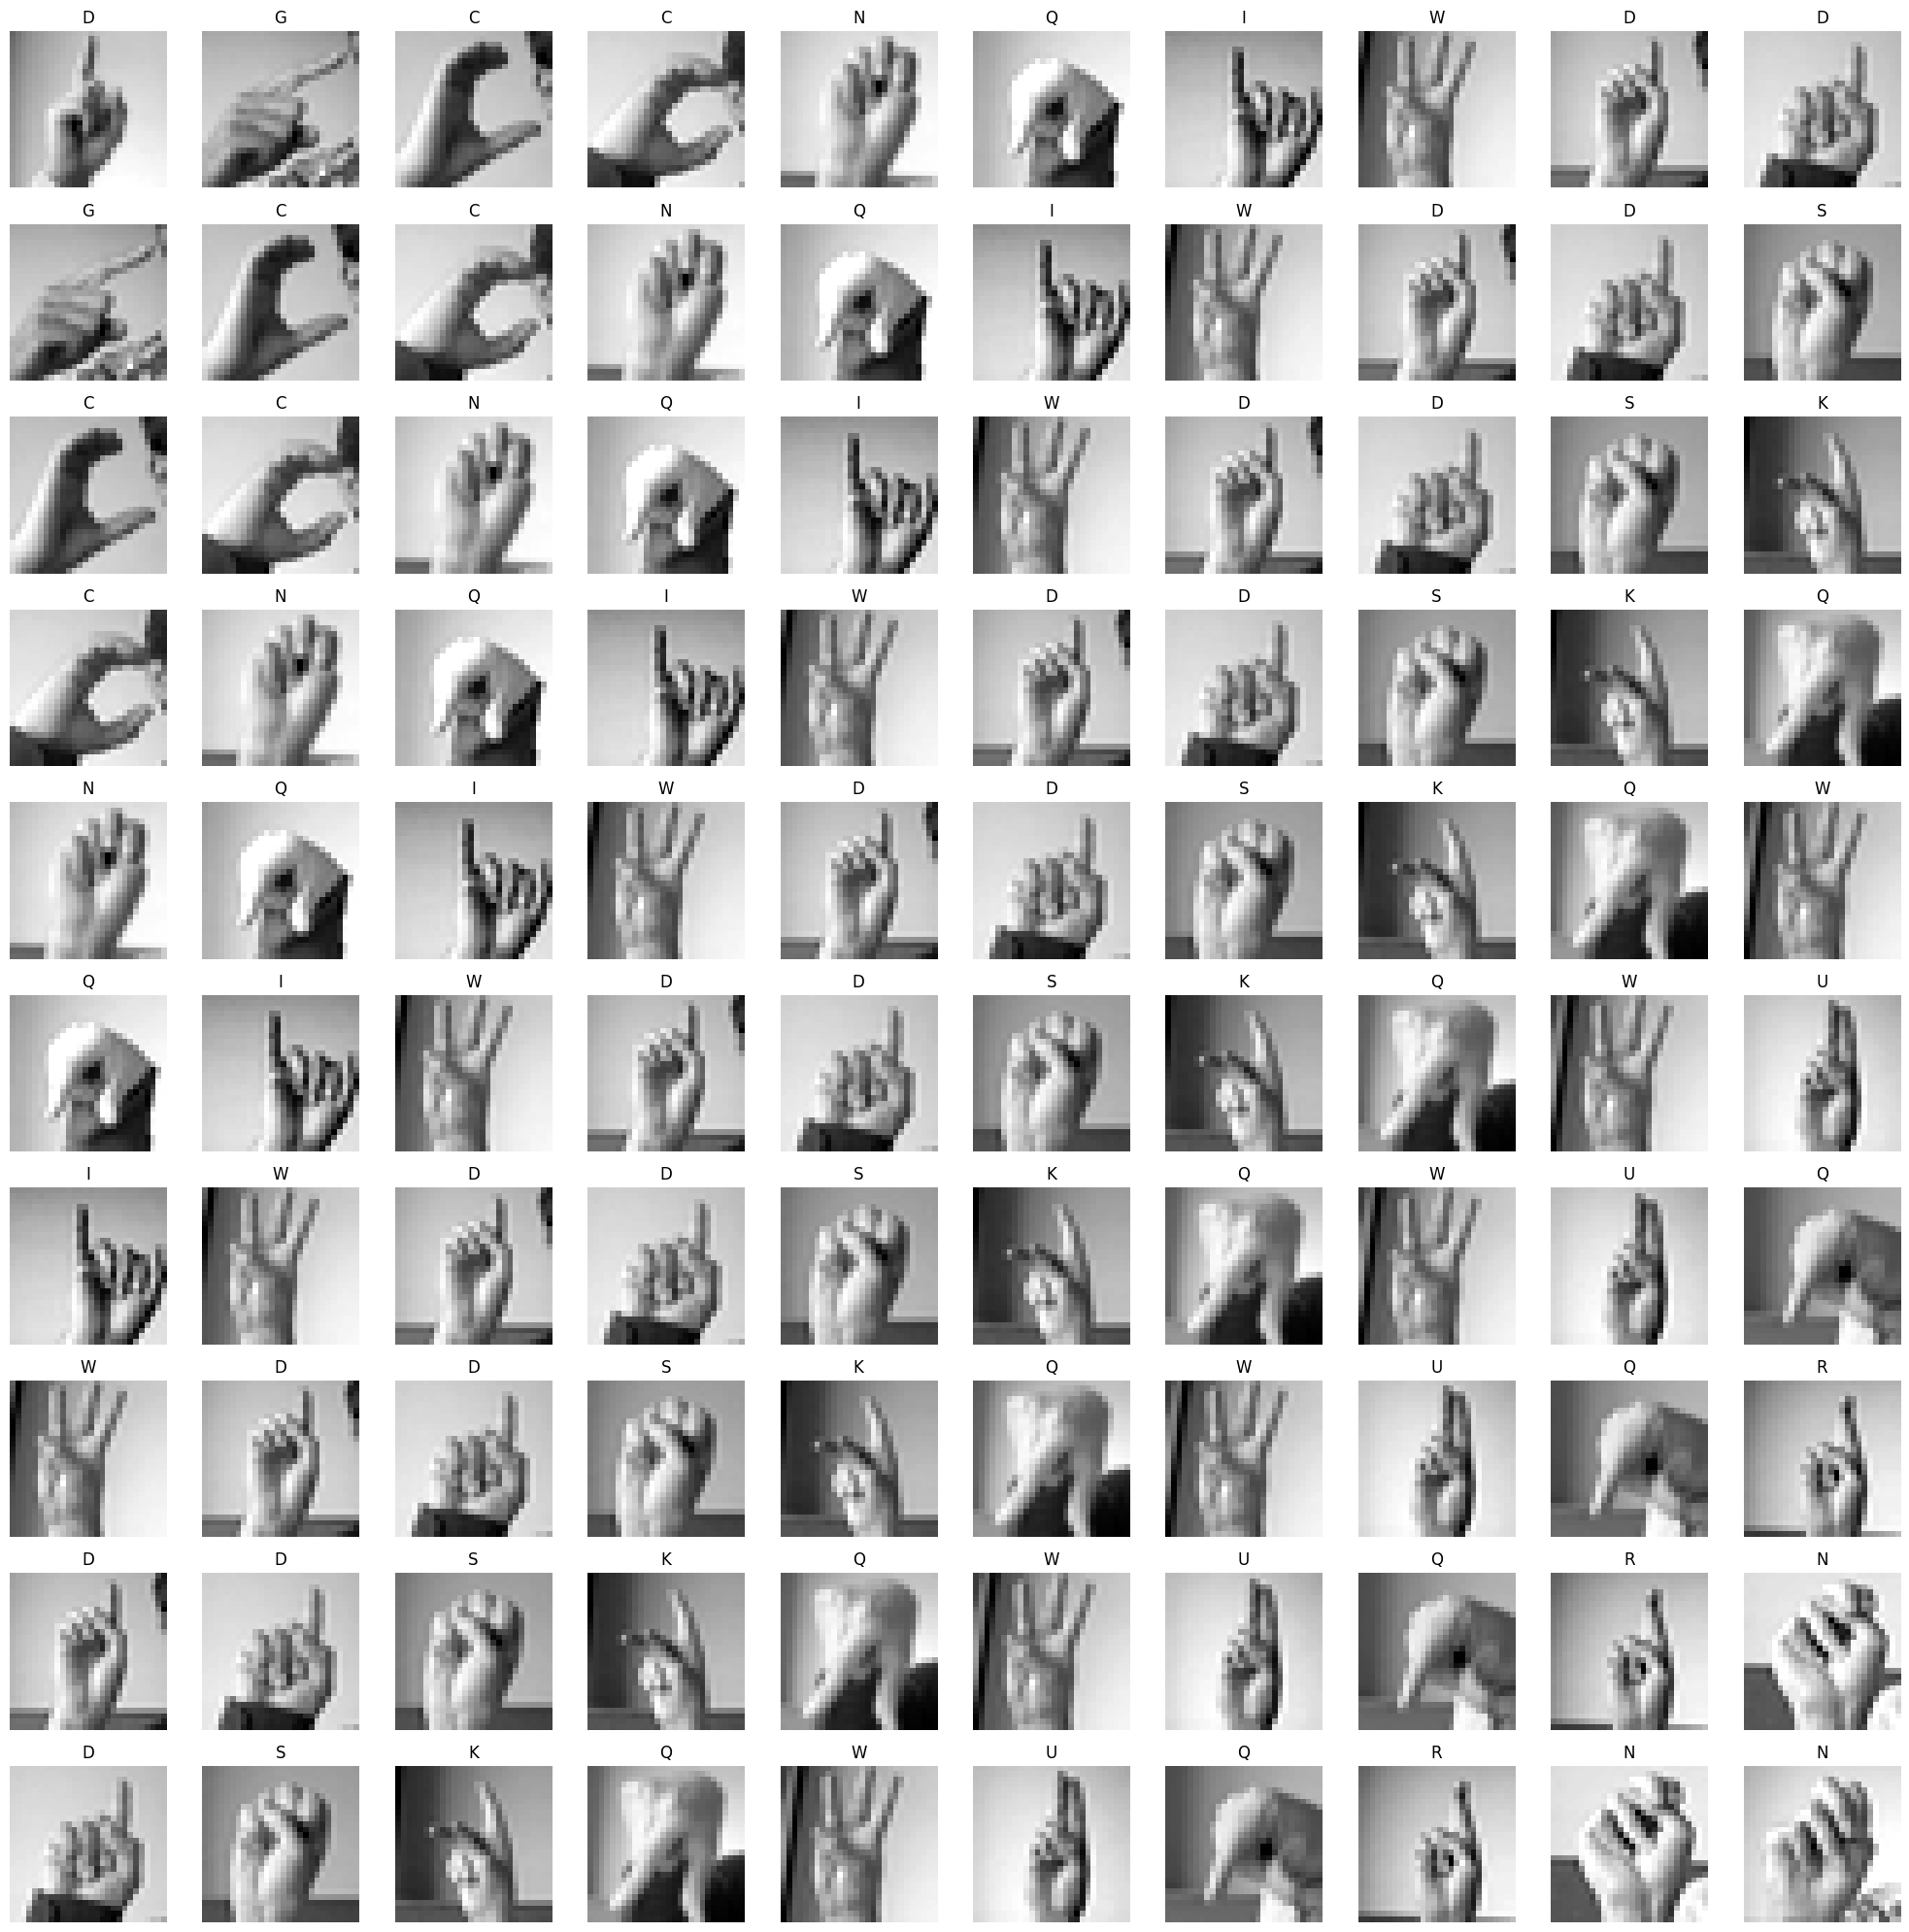

Muestras de validación


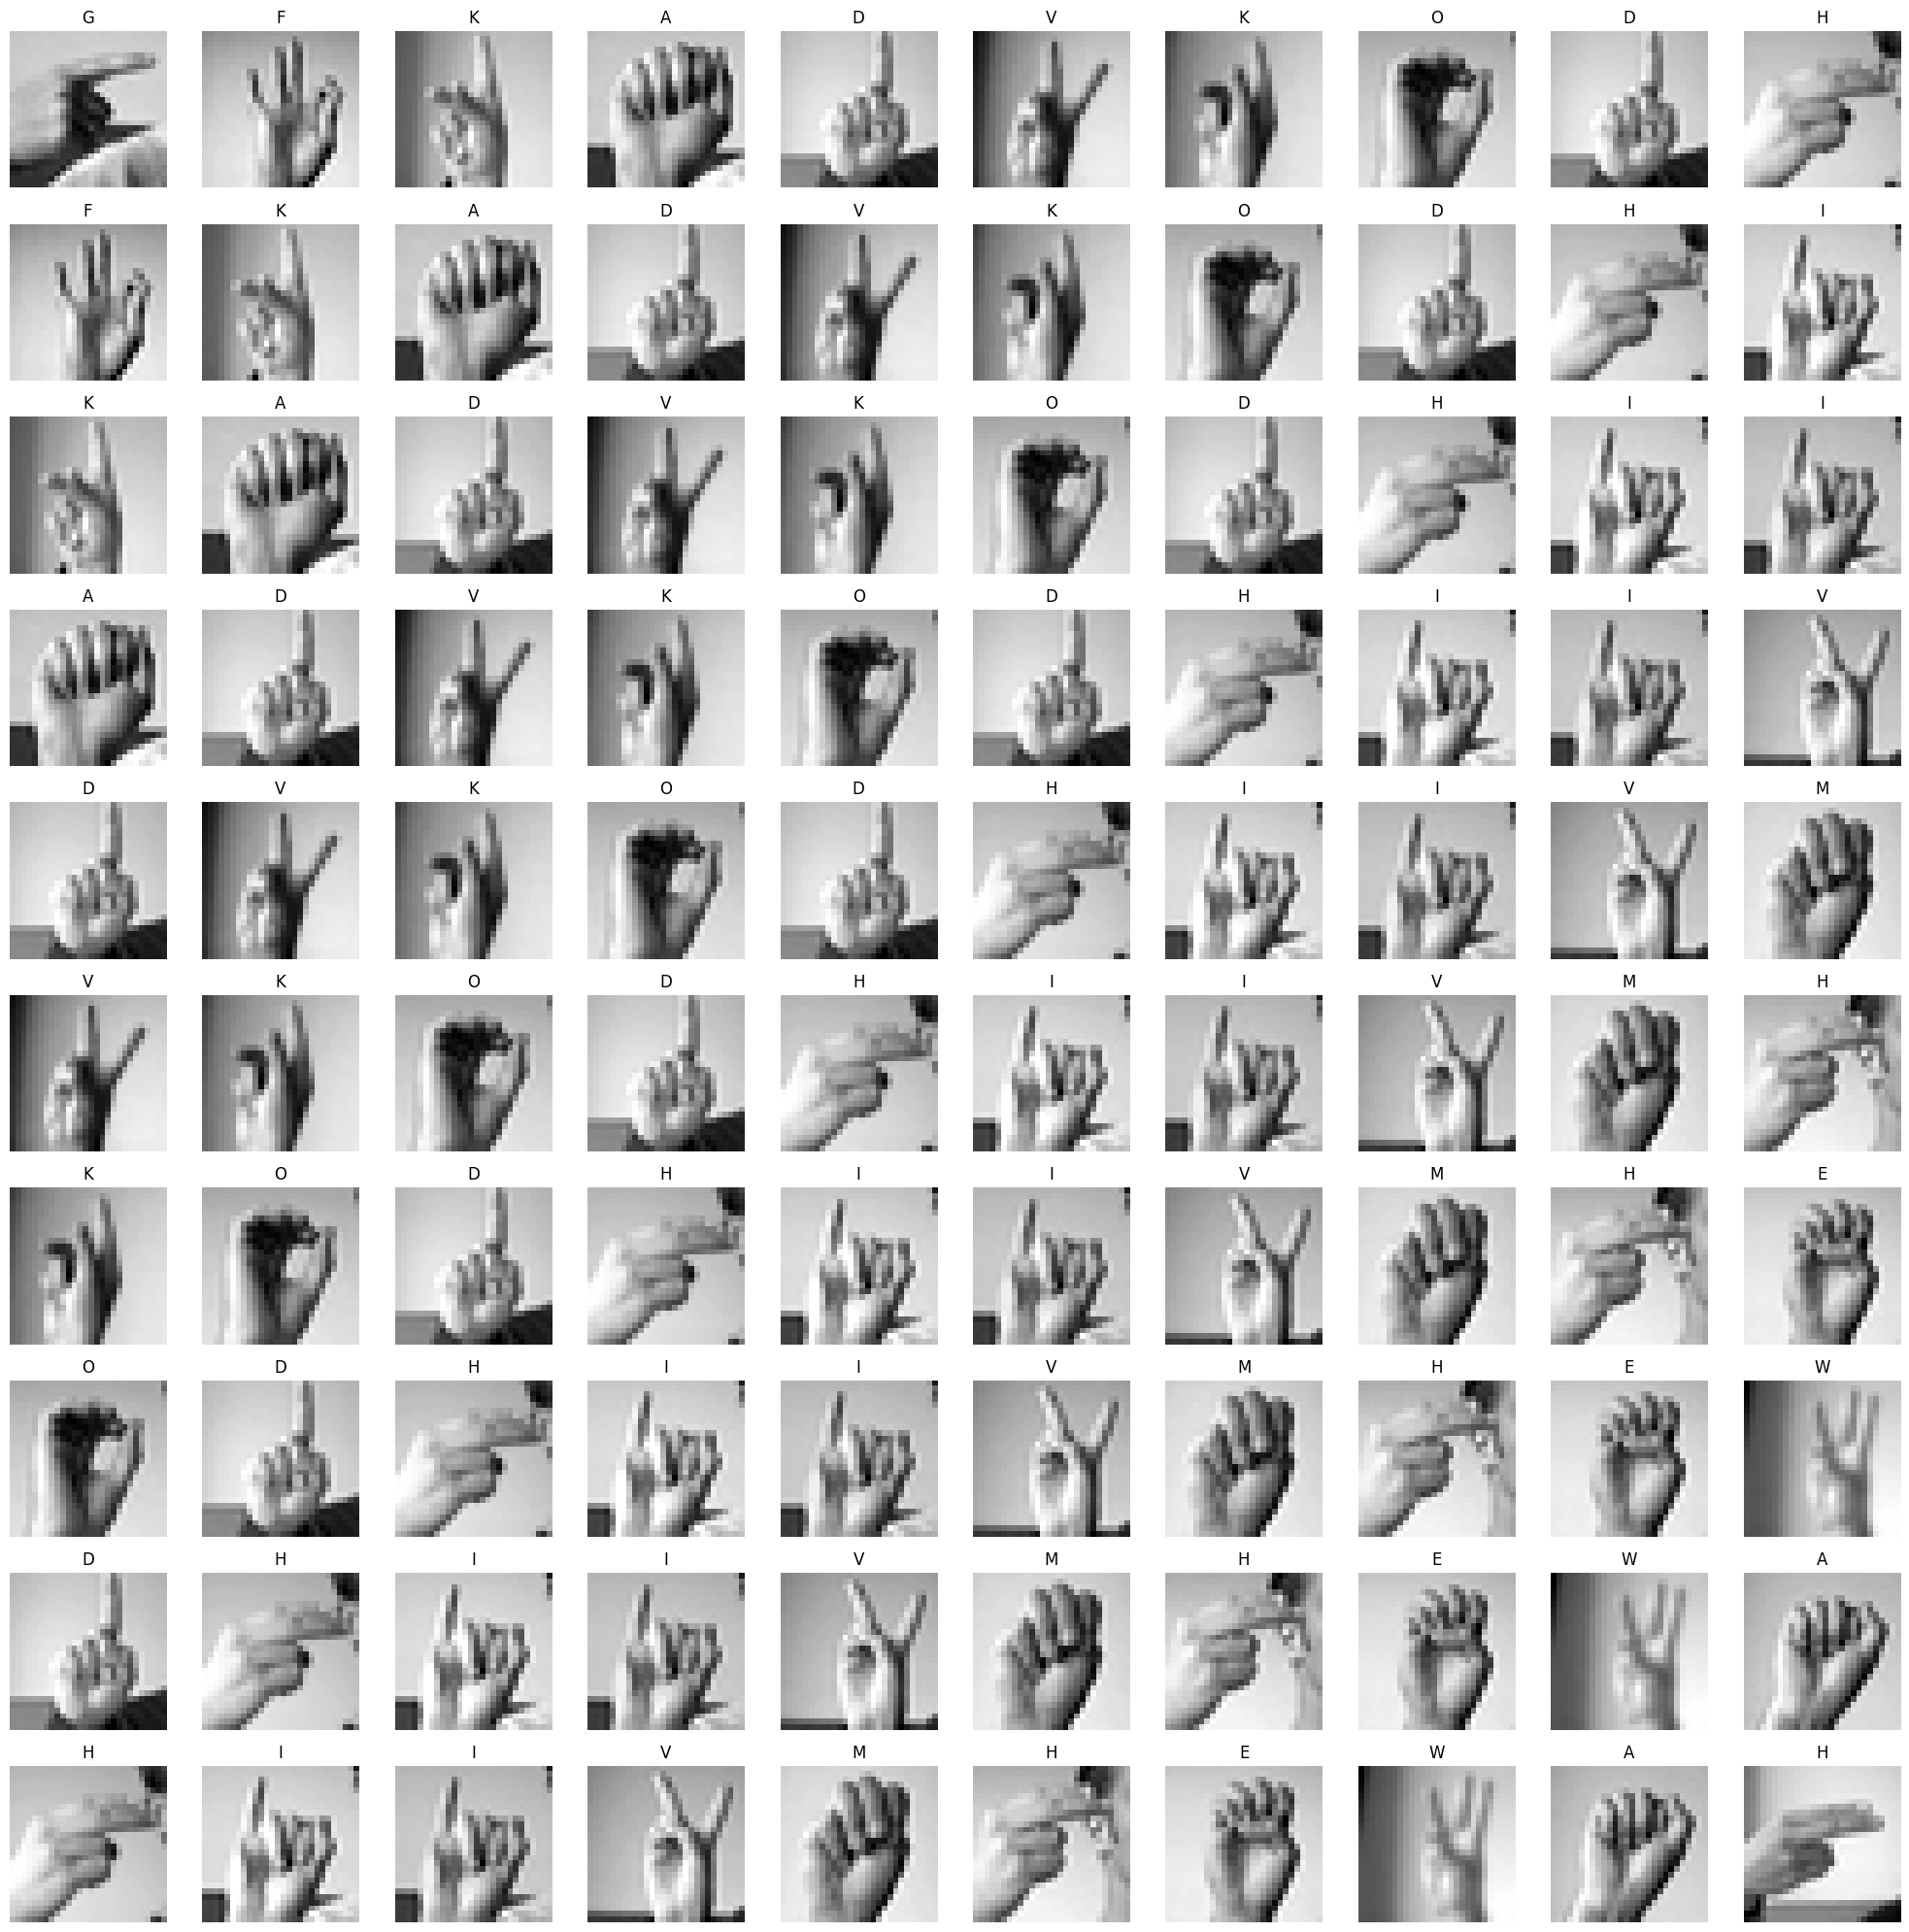

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(X, Y, nrows: int = 10, ncols: int = 10):
    # Creamos una figura de nrowsxncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))
    # Iteramos sobre las filas y las columnas de la figura
    for r in range(nrows):
        for c in range(ncols):
            # Obtenemos la imagen y su etiqueta correspondiente
            img = X[r+c, :, :, 0]
            label = i2c[Y[r+c]]
            # Plotear la imagen en el subplot actual (su título es su etiqueta)
            axs[r, c].imshow(img, cmap='gray')
            axs[r, c].set_title(label)
            axs[r, c].axis('off')
    # Ajustamos la disposición de los subplots y mostramos la figura
    plt.tight_layout()
    plt.show()

print('Muestras de entrenamiento')
plot_samples(XTrain, YTrain)
print('Muestras de validación')
plot_samples(XTest, YTest)

## MODELO

**TODO**

La CNN contiene dos bloques diferenciados:

- El bloque extractor de características. Está formado por dos bloques convolucionales.

    Cada bloque contiene una capa convolucional, seguida de una capa de BatchNormalization y finalmente, de una capa de MaxPooling2D.

    · La capa convolucional añade padding (relleno) para que la salida tenga el mismo tamaño de la entrada.

    · La capa de BatchNormalization ayuda a evitar el overfitting y además, hace que la red converja más rápido. Lo que hace, a grandes rasgos,
    es normalizar los datos de un batch para que tengan una media y una desviación concreta (valores que aprende durante el entrenamiento).

    · La capa de MaxPooling es una capa que no contiene parámetros o pesos entrenables. Lo que hace es que divide la matriz de entrada en regiones de tamaño
    igual a pool_size (en el ejemplo que te pongo (2, 2)) y de cada una de esas regiones toma el valor máximo. Así consigue reducir el tamaño de la matriz de entrada.

- El bloque clasificador de características. Contiene dos capas complementamente conectadas.

    Primero, aplanamos la matriz de salida de la última capa de pooling para convertirla en un vector. Es decir, si tenemos una matriz de 3(alto)x3(ancho)x3(profundo/canales), la capa de Flatten la pasa a un vector de 3x3x3=27 elementos.

    El vector que devuelve la capa de Flatten entra a una primera capa completamente conectada que mapea el vector a una nueva dimensión.

    Finalmente, queda la capa de clasificación donde el vector anterior se mapea a uno que tiene tantos elementos como clases hay en nuestro dataset.

    Se aplica la función de activación "softmax" que lo que hace es que devuelve una probabilidad para cada una de las clases. Estas probabilidades están normalizadas, es decir, en total suman 1.

Hacer otras pruebas cambiando aspectos de la red: número de capas, filtros, ...

Probar también a añadir un pipeline de [aumentado de datos.](https://www.tensorflow.org/tutorials/images/data_augmentation)

El objetivo es ver si esos cambios mejoran la precisión (sobre el test) de la red.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


def get_model(input_shape: tuple = (28, 28, 1), num_classes: int = 26):
    # DATA AUGMENTATION
    data_augmentation = Sequential([
    layers.RandomRotation(factor=1/12, fill_mode='nearest', input_shape=input_shape),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1,0.1), fill_mode='nearest'),
    layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
    ])

    # MODEL
    model = Sequential([
    data_augmentation,
    # Bloque extractor de características:
    # es el que le indicamos a la red
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    # Tamaño actual de los datos -> [H//2, W //2, 16]
    # La división la causa el MaxPooling y el 16 es el número de canales de salida de la capa convolucional
    # H y W son los valores originales de altura y ancho
    # // indica que la división se redondea al entero más cercano por abajo (Ej. 2.5 -> 2; 3.7 -> 3)
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    # Tamaño actual de los datos -> [H//4, W //4, 32]
    # Hemos pasado por dos capas de pooling cuyo valor por defecto es 2 para ambas dimensiones
    #--------layers.Conv2D(64, 3, padding='same', activation='relu'),
    #--------layers.MaxPooling2D(),
    # Tamaño actual de los datos -> [H//8, W //8, 64]
    layers.Dropout(0.2), # DROPOUT
    # Bloque clasificador de características:
    layers.Flatten(),
    # Por tanto, si el tamaño original es (28, 28, 1)
    # Y se ha convertido en (28//8, 28//8, 64) == (3, 3, 64)
    # Si hacemos un flatten sobre esta matriz tenemos un vector de 3x3x64=576 elementos # Si tengo 2 capas son 1568
    # Queremos empezar a reducir el tamaño de ese vector!
    # (H//4, W//4, 32) --> 576 --> 512, trabaja mejor con múltiplos de 2
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
model = get_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)      

**TODO**

Keras ofrece una función para plotear el modelo.

También existe otra [librería](https://github.com/paulgavrikov/visualkeras) un poco más sotisificada que te hace un "dibujito".



## ENTRENAMIENTO

Primero, compilamos el modelo.

- Usamos la versión "[sparse](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)" de la entropía cruzada. Esto permite que no tengamos que usar la codificación [one-hot](https://es.wikipedia.org/wiki/One-hot) y podamos usar las etiquetas tal cual nos las dan.
- Usamos el optimizador Adam con sus valores por defecto. También puedes experimentar a cambiarlos y ver qué sucede o incluso probar otro optimizador. Para ello, tendrás que llamarlo desde la librería tf.keras.optimizers.Adam(..) o el que desees.
- Por ahora, solo usamos una métrica que es la de precisión. Pero en problemas de clasificación se suele usar también la [F-1](https://es.wikipedia.org/wiki/Valor-F).
Intenta implementarla. Puedes usar o bien [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) o bien [Tensorflow Addons](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score).
- Explicación [teórica](https://mlu-explain.github.io/precision-recall/) de F-1

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Después, entrenamos el modelo. Normalmente, se suelen tener tres particiones de datos: entrenamiento, validación y test.
Esto se hace para que los cambios que se hagan sobre el modelo se hagan en base a los datos de validación y no de test, para evitar así el sobreajuste en estos.
Así que usaremos un 20% de los datos de entrenamiento para crear nuestra partición de validación.

In [ ]:
epochs = 10
batch_size = 256

print('Entrenando el modelo...')
train_history = model.fit(XTrain, YTrain, epochs=epochs, batch_size=batch_size, validation_split=0.2)
print('Evaluando el modelo...')
test_history = model.evaluate(XTest, YTest, return_dict=True)

Entrenando el modelo...
Epoch 1/10
86/86 [==============================] - 26s 274ms/step - loss: 1.6899 - accuracy: 0.5008 - val_loss: 3.4503 - val_accuracy: 0.0552
Epoch 2/10
86/86 [==============================] - 24s 279ms/step - loss: 0.5594 - accuracy: 0.8170 - val_loss: 5.8140 - val_accuracy: 0.0386
Epoch 3/10
86/86 [==============================] - 24s 278ms/step - loss: 0.2880 - accuracy: 0.9038 - val_loss: 5.9784 - val_accuracy: 0.0514
Epoch 4/10
86/86 [==============================] - 25s 291ms/step - loss: 0.1717 - accuracy: 0.9437 - val_loss: 3.6363 - val_accuracy: 0.2065
Epoch 5/10
86/86 [==============================] - 24s 278ms/step - loss: 0.1132 - accuracy: 0.9645 - val_loss: 1.2126 - val_accuracy: 0.6299
Epoch 6/10
86/86 [==============================] - 23s 270ms/step - loss: 0.0753 - accuracy: 0.9776 - val_loss: 0.2380 - val_accuracy: 0.9191
Epoch 7/10
86/86 [==============================] - 23s 267ms/step - loss: 0.0635 - accuracy: 0.9801 - val_loss: 0.045

Aquí voy a tratar de implementar la métrica F-1, debe hacerse después del entrenamiento del modelo o no tendría sentido.

In [ ]:
from sklearn.metrics import f1_score

YPred = np.argmax(model.predict(XTest), axis=1)

y_true = YTest
y_pred = YPred

f1 = f1_score(y_true, y_pred, average="macro")
print(YTest)
print(YPred)
print("Puntuación F1:", f1)

225/225 [==============================] - 4s 16ms/step
[ 6  5 10 ...  2  4  2]
[ 6  5 10 ...  2  4  2]
Puntuación F1: 0.9398936122311904


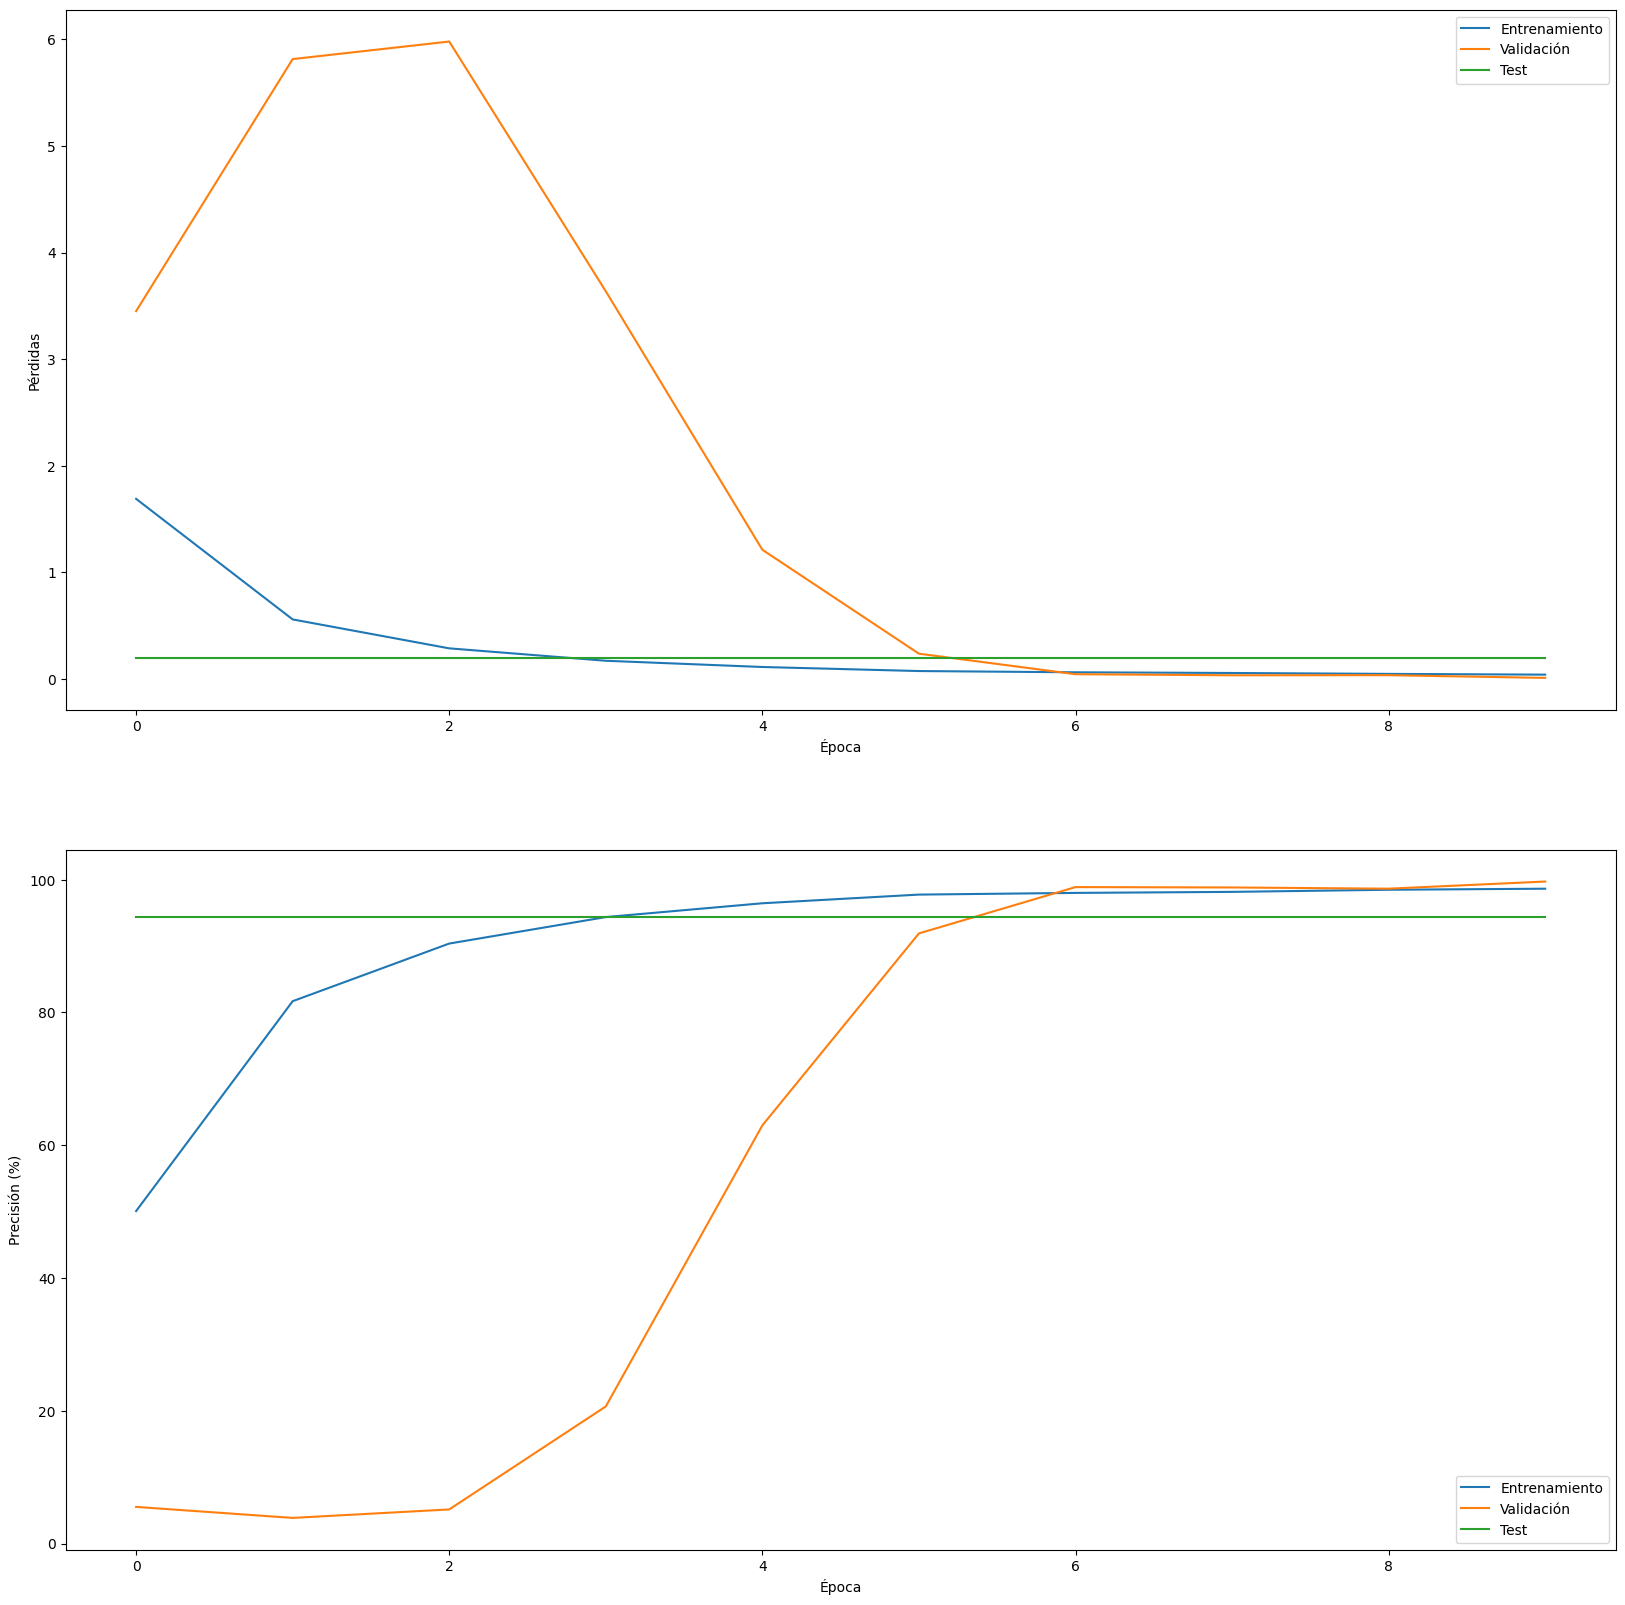

In [ ]:
def plot_metrics():
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))
    for i in range(2):
        if i == 0:
            axs[i].plot(train_history.history['loss'])
            axs[i].plot(train_history.history['val_loss'])
            axs[i].plot(np.full(shape=epochs, fill_value=test_history['loss']))
            axs[i].set_ylabel('Pérdidas')
        else:
            # Multiplicamos por 100 para obtener el porcentaje
            axs[i].plot(np.array(train_history.history['accuracy']) * 100)
            axs[i].plot(np.array(train_history.history['val_accuracy']) * 100)
            axs[i].plot(np.full(shape=epochs, fill_value=test_history['accuracy'] * 100))
            axs[i].set_ylabel('Precisión (%)')
        axs[i].set_xlabel('Época')
        axs[i].legend(['Entrenamiento', 'Validación', 'Test'])
    plt.show()

plot_metrics()

La [matriz de confusión](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n) ayuda también a evaluar qué clases le cuesta más al modelo.

225/225 [==============================] - 3s 11ms/step


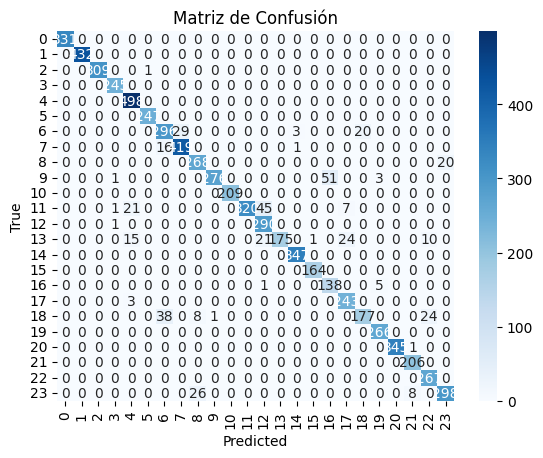

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener predicciones en el conjunto de prueba
YPred = np.argmax(model.predict(XTest), axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(YTest, YPred)

# Trazar la matriz de confusión usando seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Guardamos el mejor modelo

In [ ]:
model.save('trained_models/prueba3Andres.h5')